<a href="https://www.kaggle.com/code/rajatraj0502/adult-income-census?scriptVersionId=142256182" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-income-census/adult income1.csv


In [2]:
import pandas as pd

# Loading the CSV file
data_path = os.path.join('/kaggle/input/adult-income-census/adult income1.csv')
df = pd.read_csv(data_path)

# Displaying the first few rows of the dataframe
df.head()


age workclass  fnlwgt education  education.num marital.status  occupation  \
0   17   Private  148522      11th              7  Never-married  occupation   
1   17   Private   93235      12th              8  Never-married  occupation   
2   17   Private  184924       9th              5  Never-married  occupation   
3   17   Private  116626      11th              7  Never-married  occupation   
4   17   Private  209949      11th              7  Never-married  occupation   

  relationship   race     sex native.country income  
0    Own-child  White    Male  United-States  <=50K  
1    Own-child  White  Female  United-States  <=50K  
2    Own-child  White    Male  United-States  <=50K  
3    Own-child  White    Male  United-States  <=50K  
4    Own-child  White  Female  United-States  <=50K

In [3]:
# 1. Checking for missing values
missing_values = df.isnull().sum()

# 2. Distribution of the target variable
income_distribution = df['income'].value_counts()

# 3. Summary statistics for numerical columns
summary_statistics = df.describe()

missing_values, income_distribution, summary_statistics


(age               0
 workclass         0
 fnlwgt            0
 education         0
 education.num     0
 marital.status    0
 occupation        0
 relationship      0
 race              0
 sex               0
 native.country    0
 income            0
 dtype: int64,
 income
 <=50K    24264
 >50K      7683
 Name: count, dtype: int64,
                 age        fnlwgt  education.num
 count  31947.000000  3.194700e+04   31947.000000
 mean      38.570695  1.897319e+05      10.071149
 std       13.646280  1.057567e+05       2.561430
 min       17.000000  1.228500e+04       1.000000
 25%       28.000000  1.176275e+05       9.000000
 50%       37.000000  1.783120e+05      10.000000
 75%       48.000000  2.374535e+05      12.000000
 max       90.000000  1.484705e+06      16.000000)

In [4]:
from sklearn.preprocessing import OneHotEncoder
# Separating the target variable
X = df.drop(columns=['income'])
y = df['income'].apply(lambda x: 1 if x == '>50K' else 0)  # Convert to binary: 1 for '>50K' and 0 for '<=50K'

# One-hot encoding the categorical columns
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X.select_dtypes(include=['object'])))
# Using the updated method to get feature names
X_encoded.columns = encoder.get_feature_names_out(X.select_dtypes(include=['object']).columns)

# Concatenate the one-hot encoded columns with the numerical columns
X_final = pd.concat([X.select_dtypes(exclude=['object']), X_encoded], axis=1)

# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((25557, 98), (6390, 98))

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

accuracy


0.8148669796557121

In [6]:
# Generating a classification report
classification_rep = classification_report(y_test, y_pred, target_names=["<=50K", ">50K"])

classification_rep


'              precision    recall  f1-score   support\n\n       <=50K       0.86      0.90      0.88      4830\n        >50K       0.64      0.56      0.60      1560\n\n    accuracy                           0.81      6390\n   macro avg       0.75      0.73      0.74      6390\nweighted avg       0.81      0.81      0.81      6390\n'

In [7]:
from sklearn.model_selection import GridSearchCV
# Narrowed down hyperparameters to be tuned
param_grid_reduced = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
}

# Grid search with reduced cross-validation
grid_search_reduced = GridSearchCV(rf_classifier, param_grid_reduced, cv=2, n_jobs=-1, verbose=2)
grid_search_reduced.fit(X_train, y_train)

# Retrieve best parameters from the grid search
best_params_reduced = grid_search_reduced.best_params_

best_params_reduced


Fitting 2 folds for each of 6 candidates, totalling 12 fits


{'max_depth': 20, 'n_estimators': 100}

In [8]:
# Train a new Random Forest model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params_reduced, random_state=42, n_jobs=-1)
best_rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred_best = best_rf_classifier.predict(X_test)

# Calculate the accuracy and other metrics
accuracy_best = accuracy_score(y_test, y_pred_best)
classification_rep_best = classification_report(y_test, y_pred_best, target_names=["<=50K", ">50K"])


In [9]:
# Train a new Random Forest model with the best parameters
best_rf_classifier = RandomForestClassifier(**best_params_reduced, random_state=42, n_jobs=-1)
best_rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred_best = best_rf_classifier.predict(X_test)

# Calculate the accuracy and generate the classification report
accuracy_best = accuracy_score(y_test, y_pred_best)
classification_rep_best = classification_report(y_test, y_pred_best, target_names=["<=50K", ">50K"])

accuracy_best, classification_rep_best


(0.8381846635367762,
 '              precision    recall  f1-score   support\n\n       <=50K       0.87      0.93      0.90      4830\n        >50K       0.72      0.56      0.63      1560\n\n    accuracy                           0.84      6390\n   macro avg       0.79      0.74      0.76      6390\nweighted avg       0.83      0.84      0.83      6390\n')

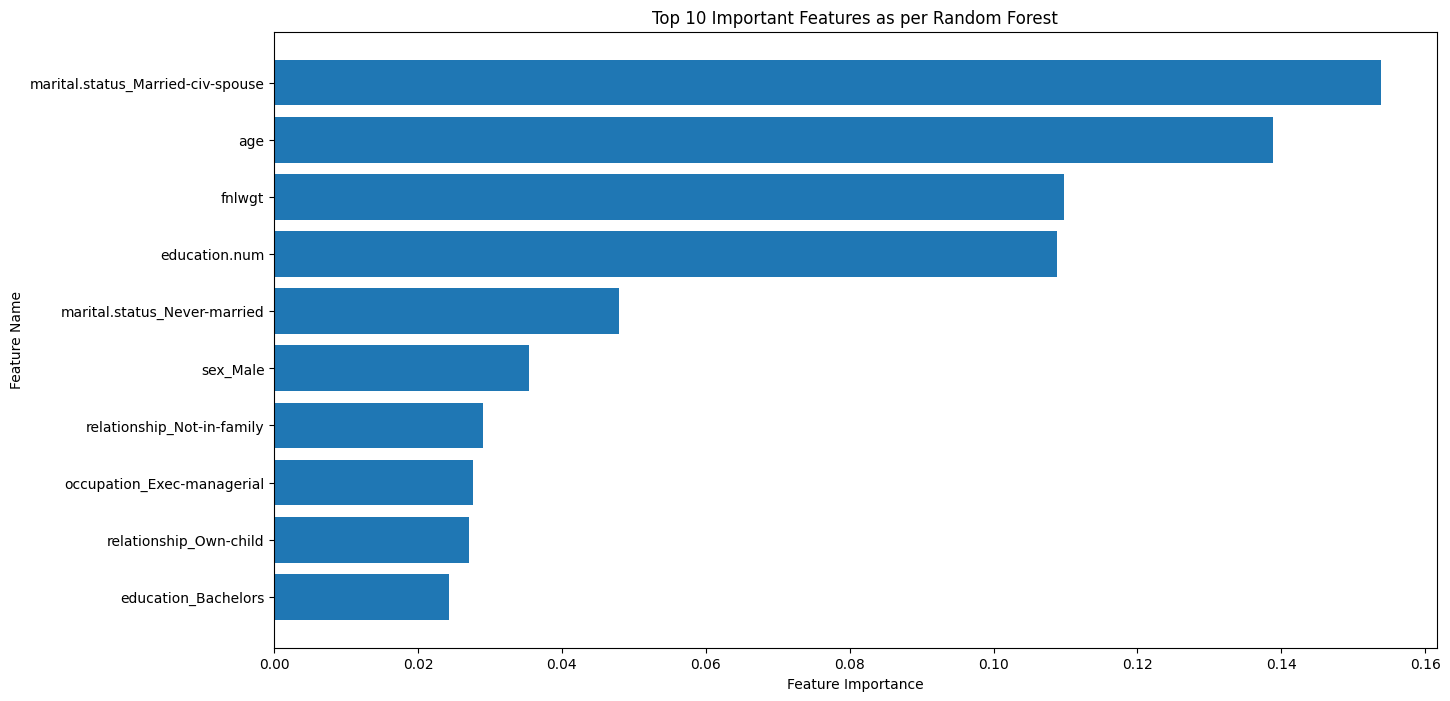

In [10]:
import matplotlib.pyplot as plt

# Get feature importances
feature_importances = best_rf_classifier.feature_importances_

# Match importances with their respective feature names and sort them
features = sorted(zip(feature_importances, X_train.columns), reverse=True)[:10]

# Separate out the feature names and their importance values
importance_values = [x[0] for x in features]
feature_names = [x[1] for x in features]

# Plot the top 10 features
plt.figure(figsize=(15, 8))
plt.barh(feature_names, importance_values, align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Important Features as per Random Forest')
plt.gca().invert_yaxis()  # Display the most important feature at the top
plt.show()


In [11]:
from sklearn.model_selection import cross_val_score

# Cross-validation with 5 folds
scores = cross_val_score(best_rf_classifier, X_final, y, cv=5, scoring='accuracy')
mean_accuracy = scores.mean()


In [12]:
import xgboost as xgb

xgb_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)


In [13]:
from joblib import dump, load

# Save the model to a file
dump(best_rf_classifier, 'random_forest_model.joblib') 

# Load the model later using:
# loaded_model = load('random_forest_model.joblib')


['random_forest_model.joblib']

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and context for seaborn plots
sns.set_style("whitegrid")
sns.set_context("talk")

# Define a custom color palette (feel free to adjust!)
palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
sns.set_palette(palette)


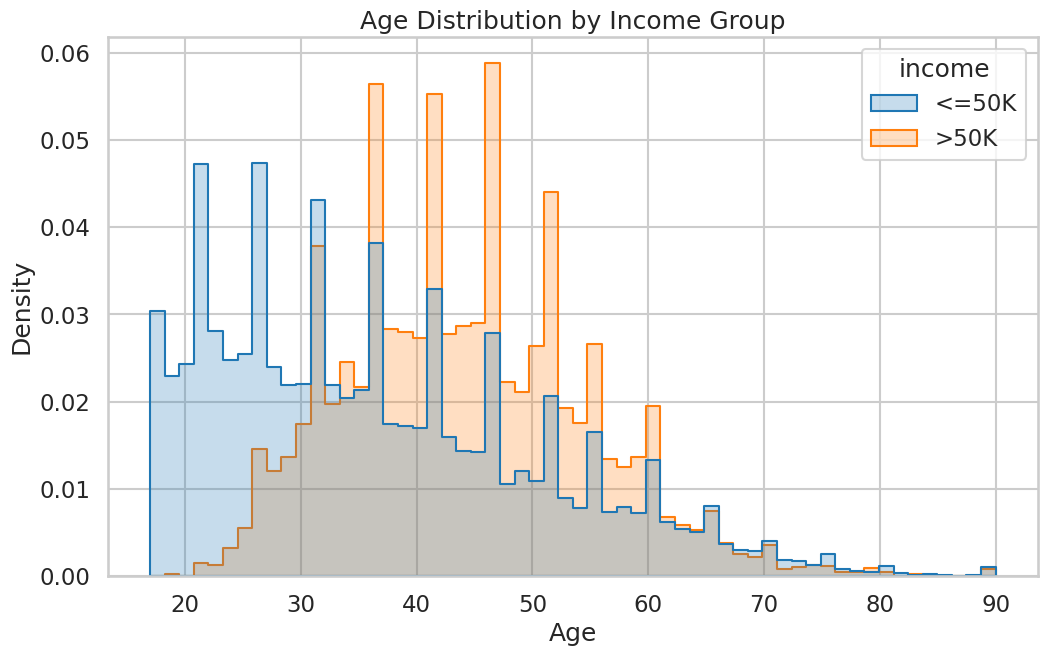

In [15]:
plt.figure(figsize=(12, 7))
sns.histplot(df, x="age", hue="income", element="step", stat="density", common_norm=False)
plt.title('Age Distribution by Income Group')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()


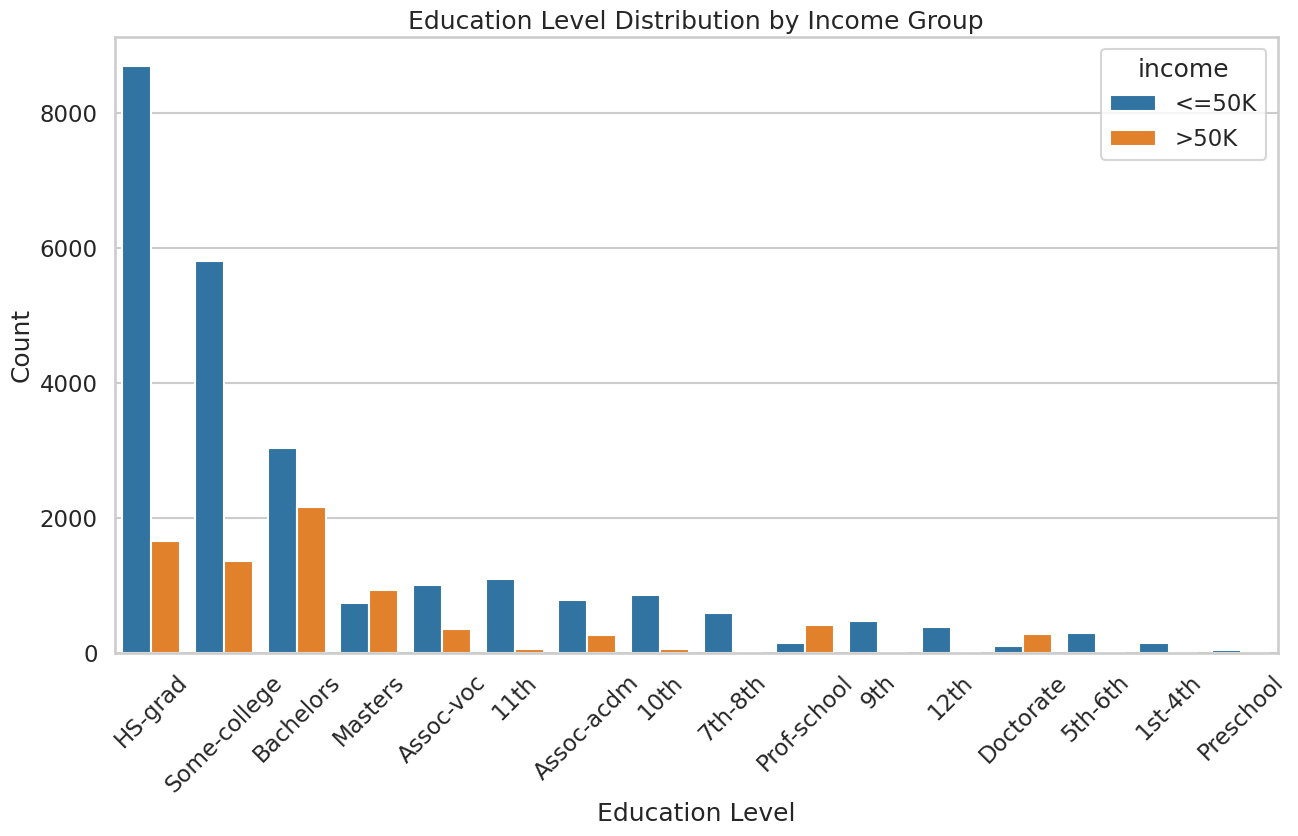

In [16]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x="education", hue="income", order=df['education'].value_counts().index)
plt.title('Education Level Distribution by Income Group')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


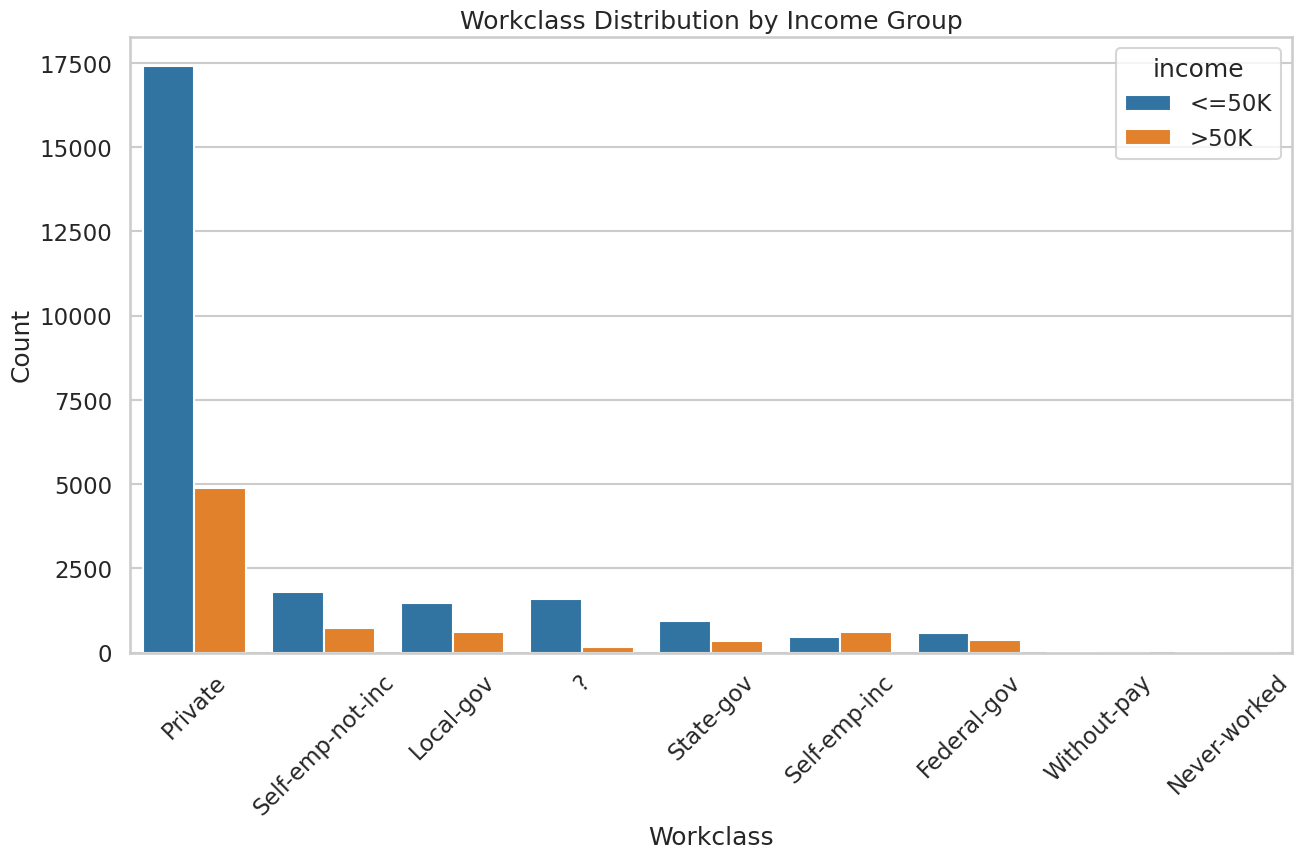

In [17]:
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x="workclass", hue="income", order=df['workclass'].value_counts().index)
plt.title('Workclass Distribution by Income Group')
plt.xlabel('Workclass')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


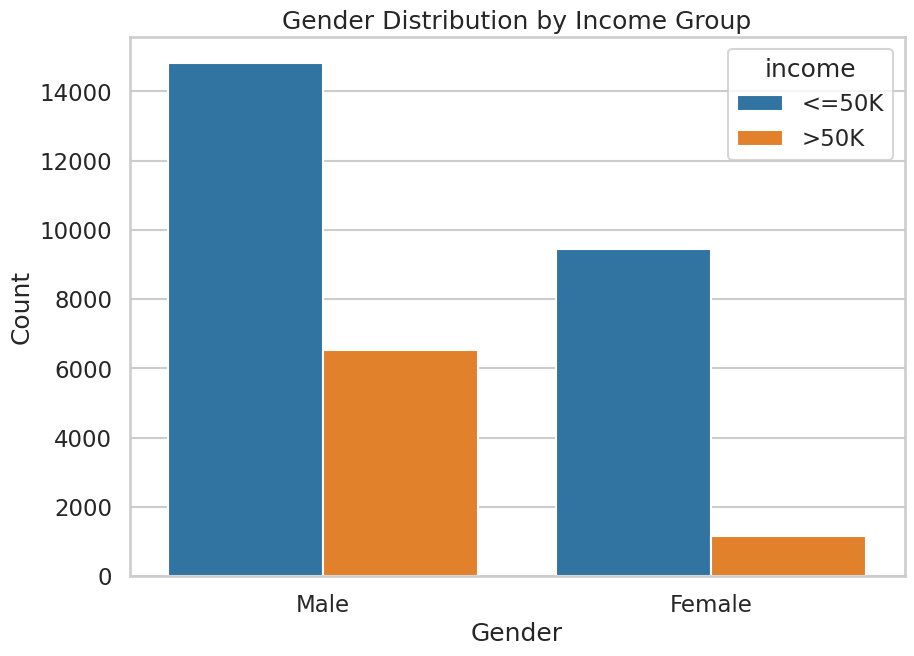

In [18]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x="sex", hue="income")
plt.title('Gender Distribution by Income Group')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [19]:
!pip install plotly


In [20]:
import plotly.express as px

fig = px.histogram(df, x="age", color="income", marginal="box", nbins=40,
                   color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                   title="Age Distribution by Income Group")
fig.show()


In [21]:
fig = px.histogram(df, x="education", color="income", 
                   category_orders={"education": df['education'].value_counts().index.tolist()},
                   color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                   title="Education Level Distribution by Income Group")
fig.show()


In [22]:
fig = px.histogram(df, x="workclass", color="income", 
                   category_orders={"workclass": df['workclass'].value_counts().index.tolist()},
                   color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                   title="Workclass Distribution by Income Group")
fig.show()


In [23]:
fig = px.histogram(df, x="sex", color="income", 
                   color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                   title="Gender Distribution by Income Group")
fig.show()


In [24]:
import plotly.graph_objects as go

# Filter for only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate mean values for the two income groups
grouped = df.groupby('income')[numeric_cols].mean().reset_index()

features = ['age', 'fnlwgt', 'education.num']

fig = go.Figure()

for income, color in [('<=50K', '#636EFA'), ('>50K', '#EF553B')]:
    fig.add_trace(go.Scatterpolar(
        r=grouped[grouped['income'] == income][features].values[0],
        theta=features,
        fill='toself',
        name=income,
        line_color=color
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
        )),
    showlegend=True,
    title="Radar Chart Comparing Mean Values by Income Group"
)

fig.show()


In [25]:
relationship_counts = df['relationship'].value_counts().reset_index()
relationship_counts.columns = ['relationship', 'count']

fig = px.pie(relationship_counts, names='relationship', values='count', hole=0.3,
             title="Donut Chart: Distribution of Relationship Statuses")
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()


In [26]:
occupation_education = df.groupby(['education', 'occupation', 'income']).size().reset_index(name='counts')

fig = px.sunburst(occupation_education, path=['education', 'occupation', 'income'], values='counts',
                  color='income', 
                  color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                  title="Sunburst Chart: Occupation within Education Levels by Income Group")
fig.show()


In [27]:
fig = px.parallel_categories(df, dimensions=['education', 'marital.status', 'occupation', 'income'],
                             color=df['age'], 
                             color_continuous_scale=px.colors.sequential.Inferno,
                             title="Parallel Categories Diagram of Education, Marital Status, Occupation by Age")
fig.show()


In [28]:
education_workclass_age = df.groupby(['education', 'workclass']).agg({'age':'mean', 'fnlwgt':'count'}).reset_index()

fig = px.treemap(education_workclass_age, 
                 path=['education', 'workclass'], 
                 values='fnlwgt', 
                 color='age',
                 color_continuous_scale='RdBu',
                 title="Treemap: Distribution of Workclass within Education Levels by Average Age")
fig.show()


In [29]:
df.columns


Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'native.country', 'income'],
      dtype='object')

In [30]:
import plotly.express as px

fig = px.scatter_3d(df, 
                    x='age', 
                    y='education.num', 
                    z='fnlwgt',
                    color='income', 
                    color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                    title="3D Scatter Plot of Age, Education Number, and Final Weight by Income")
fig.show()


In [31]:
import plotly.graph_objects as go

# Count of each education level
education_counts = df['education'].value_counts()

# Create a donut chart
fig = go.Figure(data=[go.Pie(labels=education_counts.index,
                             values=education_counts.values,
                             hole=.3)])  # This creates the 'donut' shape

fig.update_layout(title_text="Distribution of Educational Qualifications")
fig.show()


In [32]:
fig = px.violin(df, y='age', x='workclass', box=True, points="all",
                color='income', 
                color_discrete_map={'<=50K': '#636EFA', '>50K': '#EF553B'},
                title="Age Distribution by Workclass")

fig.show()


In [33]:
# Create a pivot table for the heatmap
heatmap_data = df.pivot_table(index='education', columns='occupation', aggfunc='size', fill_value=0)

fig = px.imshow(heatmap_data, 
                title="Relationship between Education and Occupation",
                color_continuous_scale=px.colors.sequential.Inferno)

fig.show()
